# CTA AEFF interpolation

There was a report of possible bugs with CTA DC-1 AEFF interpolation via email.

In this notebook we have a quick look.

As far as I can see, everything is as expected and as good as it can be
(given the somewhat noisy IRFs from CTA, and assuming we're not introducing smoothing in Gammapy for now).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u 
from astropy.table import Table
from gammapy.irf import EffectiveAreaTable2D

## Bins and nodes

Everything looks as expected to me.

Note that CTA IRFs currently are produced from diffuse photons and IRFs computed in offset bins of 0 to 1 deg, 1 to 2 deg and so on. In Gammapy, we choose to put the node for the interpolation at the bin center in offset, i.e. the first node is at 0.5 deg, the second at 1.5 deg and so on.

In [2]:
filename = '1dc/1dc/caldb/data/cta/1dc/bcf/North_z20_50h/irf_file.fits'
aeff = EffectiveAreaTable2D.read(filename)

In [3]:
# Just to compare, what the raw IRF BINTABLE HDU contains
table = Table.read(filename, hdu='EFFECTIVE AREA')
table

ENERG_LO [42],ENERG_HI [42],THETA_LO [6],THETA_HI [6],"EFFAREA [6,42]"
TeV,TeV,deg,deg,m2
float32,float32,float32,float32,float32
0.0125893 .. 158.489,0.0158489 .. 199.526,0.0 .. 5.0,1.0 .. 6.0,398.67 .. 220125.0


In [4]:
print(aeff)

EffectiveAreaTable2D
NDDataArray summary info
energy         : size =    42, min =  0.014 TeV, max = 177.828 TeV
offset         : size =     6, min =  0.500 deg, max =  5.500 deg
Data           : size =   252, min =  0.000 m2, max = 1303965.500 m2



In [5]:
energy_axis = aeff.data.axes[0]
print(energy_axis)
energy_axis.nodes.value

BinnedDataAxis
Name: energy
Unit: TeV
Nodes: 42
Interpolation mode: log
Lower bounds [  1.25892544e-02   1.58489328e-02   1.99526232e-02   2.51188651e-02
   3.16227749e-02   3.98107171e-02   5.01187220e-02   6.30957335e-02
   7.94328228e-02   1.00000001e-01   1.25892535e-01   1.58489317e-01
   1.99526235e-01   2.51188636e-01   3.16227764e-01   3.98107171e-01
   5.01187205e-01   6.30957365e-01   7.94328213e-01   1.00000000e+00
   1.25892544e+00   1.58489323e+00   1.99526227e+00   2.51188636e+00
   3.16227770e+00   3.98107171e+00   5.01187229e+00   6.30957365e+00
   7.94328213e+00   1.00000000e+01   1.25892544e+01   1.58489323e+01
   1.99526234e+01   2.51188641e+01   3.16227760e+01   3.98107185e+01
   5.01187248e+01   6.30957336e+01   7.94328232e+01   1.00000000e+02
   1.25892540e+02   1.58489319e+02] TeV
Upper bounds [  1.58489328e-02   1.99526232e-02   2.51188651e-02   3.16227749e-02
   3.98107171e-02   5.01187220e-02   6.30957335e-02   7.94328228e-02
   1.00000001e-01   1.25892535e-01

array([  1.41253760e-02,   1.77827943e-02,   2.23872121e-02,
         2.81838290e-02,   3.54813375e-02,   4.46683578e-02,
         5.62341325e-02,   7.07945824e-02,   8.91250968e-02,
         1.12201840e-01,   1.41253754e-01,   1.77827939e-01,
         2.23872110e-01,   2.81838298e-01,   3.54813367e-01,
         4.46683586e-01,   5.62341332e-01,   7.07945824e-01,
         8.91250908e-01,   1.12201846e+00,   1.41253757e+00,
         1.77827942e+00,   2.23872113e+00,   2.81838298e+00,
         3.54813385e+00,   4.46683598e+00,   5.62341356e+00,
         7.07945776e+00,   8.91250896e+00,   1.12201853e+01,
         1.41253757e+01,   1.77827950e+01,   2.23872108e+01,
         2.81838284e+01,   3.54813385e+01,   4.46683617e+01,
         5.62341347e+01,   7.07945786e+01,   8.91250916e+01,
         1.12201843e+02,   1.41253754e+02,   1.77827942e+02], dtype=float32)

In [6]:
offset_axis = aeff.data.axes[1]
print(offset_axis)
print(offset_axis.nodes.value)

BinnedDataAxis
Name: offset
Unit: deg
Nodes: 6
Interpolation mode: linear
Lower bounds [ 0.  1.  2.  3.  4.  5.] deg
Upper bounds [ 1.  2.  3.  4.  5.  6.] deg
[ 0.5  1.5  2.5  3.5  4.5  5.5]


## Peek

Let's have a quick look at AEFF, and especially at the extrapolation to offset = 0 deg.

Everything looks as expected: the AEFF values at offset = 0 deg are the linear extrapolation of the values at the two nearest nodes from offset = 0.5 deg and 1.5 deg.

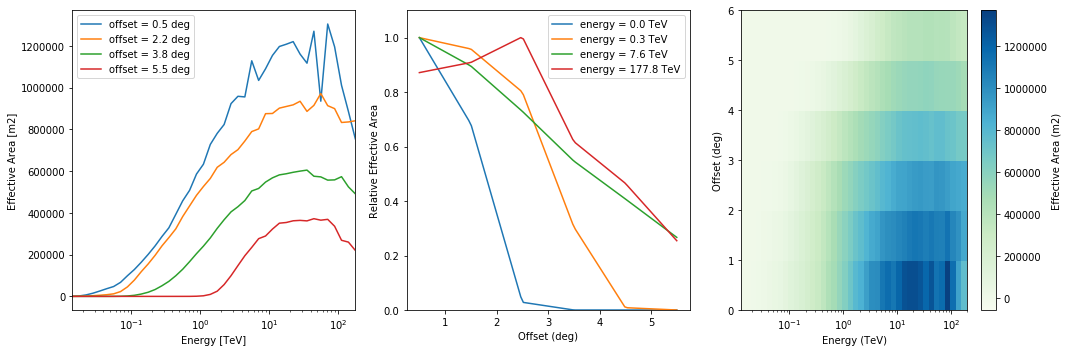

In [7]:
aeff.peek()

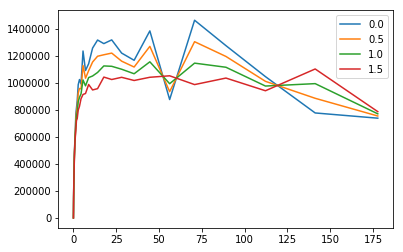

In [8]:
for offset in np.arange(0, 2, 0.5):
    val = aeff.data.evaluate(offset=offset*u.deg)
    plt.plot(energy_axis.nodes.value, val, label=offset)
plt.legend()

## Evaluate at nodes

We're using bilinear interpolation in energy and offset, so evaluating at nodes should give the exact same values as the data array.

In [9]:
# If no energy and offset is passed, the interpolator is called at the nodes by default
val = aeff.data.evaluate()
val2 = aeff.data.data
diff = val - val2
print(diff.max())

0.0 m2
